In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [38]:
train = pd.read_csv('../input/train.csv')
print(train.shape)
train.head()

(595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


# Data Description
As is shown in the table above, the characteristics of the data are as follows:
1. The size of train data set is (595212, 59), which means there are 595212 samples for trainning and each sample has 57 features(not including 'id' and 'target').
2. Feature names contain postfix 'bin' to indicate binary features and 'cat' to indicate categorical features. Features without postfix mentioned above are either continuous or ordinal. 
3. Values of -1 indicate that the feature value was missing.
4. In order to deal with data better, we classify the features as 4 types as follow.


In [39]:
cat_features = []
bin_features = []
continue_features = []
ordinal_features = []
for i in train.columns[2:]:
    if i.endswith('_bin'):
        bin_features.append(i)
    elif i.endswith('_cat'):
        cat_features.append(i)
    elif train[i].dtype == 'float64':
        continue_features.append(i)
    elif train[i].dtype == 'int64':
        ordinal_features.append(i)
print ('categorical features:')
print (cat_features)
print ('binary features:')
print (bin_features)
print ('continue features:')
print (continue_features)
print ('ordinal features:')
print (ordinal_features)

categorical features:
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
binary features:
['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
continue features:
['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']
ordinal features:
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']


Percentage of target = 1 : 3.6447517859182947 %


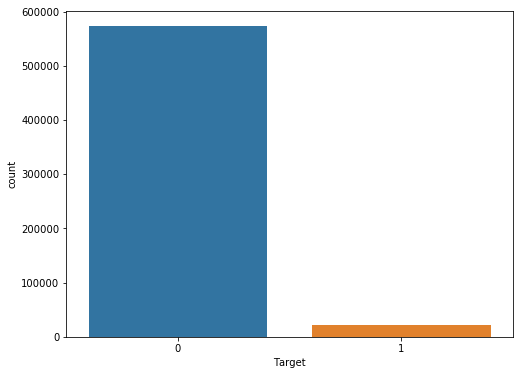

In [58]:
plt.figure(figsize=(8,6))
sns.countplot(train['target'])
plt.xlabel('Target')
print ('Percentage of target = 1 :',(train['target'].sum()/train.shape[0])*100,'%')

As we can see, the **target** value is **imbalanced** so that we need to be careful.

 ## (a) Missing Values
Because values of -1 indicate that the feature was missing from the observation, the distribution of missing values can be shown by counting numbers of '-1' of each column.

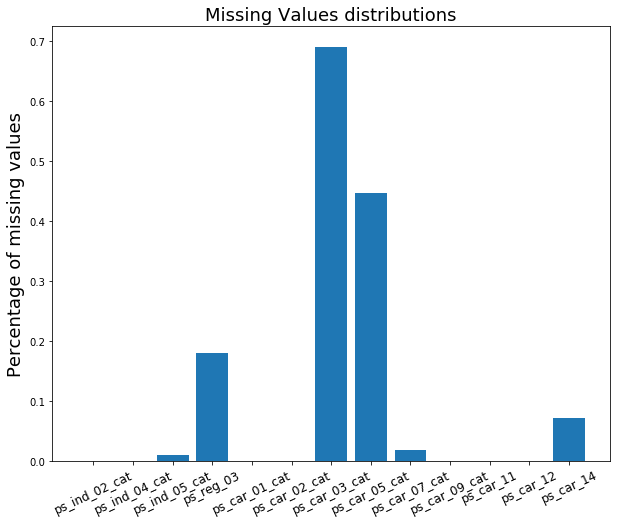

In [40]:
miss_features = []
miss_perc = []
miss_cat = []
for f in train.columns:
    miss = train[train[f] == -1][f].count()
    if miss > 0:
        miss_features.append(f)
        if f.endswith('_cat'):
            miss_cat.append(f)
        miss_perc.append(miss/train.shape[0])
plt.figure(figsize=(10,8))
plt.bar(range(len(miss_features)),miss_perc)
plt.xticks(range(len(miss_features)),miss_features,rotation=25,fontsize=12)
plt.ylabel('Percentage of missing values',fontsize=18)
plt.title('Missing Values distributions',fontsize=18)

As we can see above, there are 13 features that contains missing values. Especially,  '**ps_reg_03**', '**ps_car_03_cat**', '**ps_car_05_cat**' and '**ps_car_14**' have many missing values to be handled.

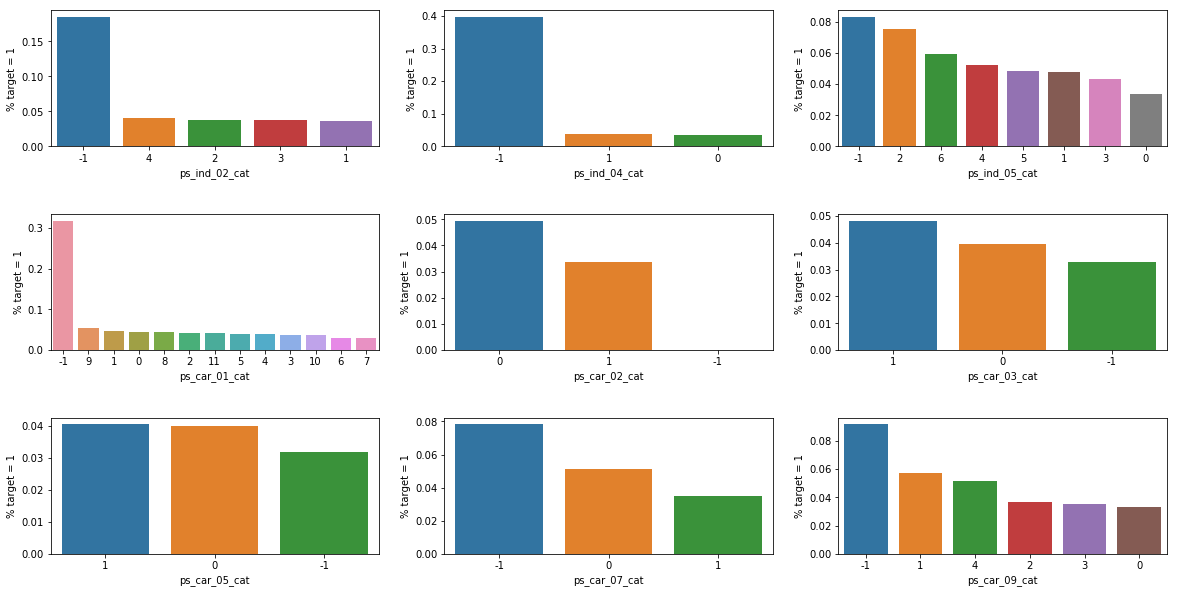

In [50]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(3,3,figsize=(20,10))
for i in range(len(miss_cat)):
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[miss_cat[i], 'target']].groupby([miss_cat[i]],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax[int(i/3),i%3], x=miss_cat[i], y='target', data=cat_perc, order=cat_perc[miss_cat[i]])
    ax[int(i/3),i%3].set_ylabel('% target = 1')
    ax[int(i/3),i%3].set_xlabel(miss_cat[i])
    #plt.tick_params(axis='both', which='major', labelsize=18)
fig.subplots_adjust(hspace=0.5)
plt.show()

From the figure above, we can see that the proportions of missing values for some features are large, so **keeping the missing values as a separate category value** would be better than replacing them by the mode. These features are as follow:
1. 'ps_ind_02_cat'
2. 'ps_ind_04_cat'
3. 'ps_ind_05_cat'
4. 'ps_car_01_cat'
5. 'ps_car_03_cat'
6. 'ps_car_05_cat'
7. 'ps_car_07_cat'
8. 'ps_car_09_cat'

Maybe the customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim. 
## (b) Handling Missing Values
According to the features classification, we can handle features as follow:
1. '**ps_car_03_cat**' and  '**ps_car_05_cat**' have a large proportion of missing values, so at first we **remove** these two features.
2. '**ps_reg_03**', '**ps_car_12**', and '**ps_car_14**' are continuous values, so we replace the missing values by the **mean**.
3. Missing values of **other** features are replaced by the **mode**. 


# Data Visualization
In order to understand the data better, we use some figures to show the relationship between features and target.
## Categorical Features
### Relationships between Categorical features and the target.

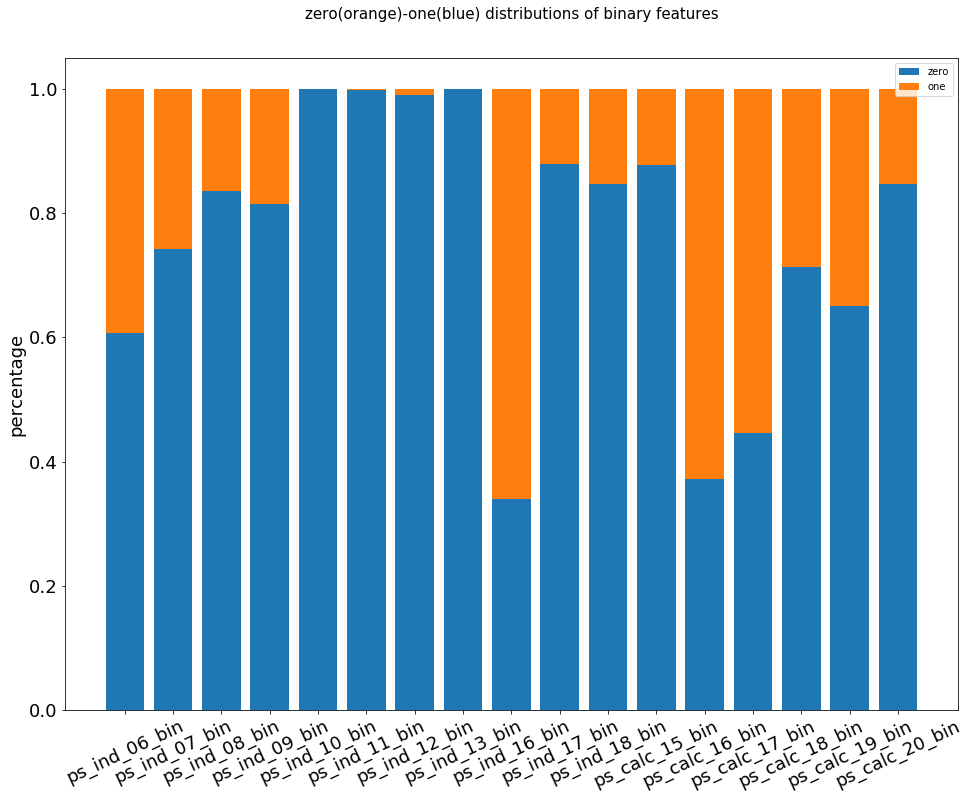

In [42]:
plt.figure(figsize=(16,12))
#bin_count = pd.DataFrame()
one_count = []
zero_count = []
total_samples = train.shape[0]
for f in bin_features:
    # Calculate the percentage of target=1 per category value
    ones = train[f].sum()/total_samples*1.0
    one_count.append(ones)
    zero_count.append(1-ones)
    #d = [temp['target'][0],temp['target'][1]]
    #new = pd.DataFrame(data=d, columns=[f])
    #bin_count = pd.concat([bin_count,new],axis=1)
# Bar plot
# Order the bars descending on target mean
#sns.barplot(ax=ax, x=bin_features, y='target', data=bin_count, order=cat_perc[f])
plt.bar(range(len(bin_features)), zero_count, label='zero')
plt.bar(range(len(bin_features)), one_count, bottom=zero_count, label='one')

plt.title('zero(orange)-one(blue) distributions of binary features', y=1.05, size=15)
plt.ylabel('percentage', fontsize=18)
plt.xticks(range(len(bin_features)), bin_features,rotation=25 , fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend()
plt.show()

As we can see, '**ps_ind_09_bin**', '**ps_ind_10_bin**', '**ps_ind_11_bin**', and '**ps_ind_12_bin**' are **almost full zeros**, so these four features might not be important to the target.

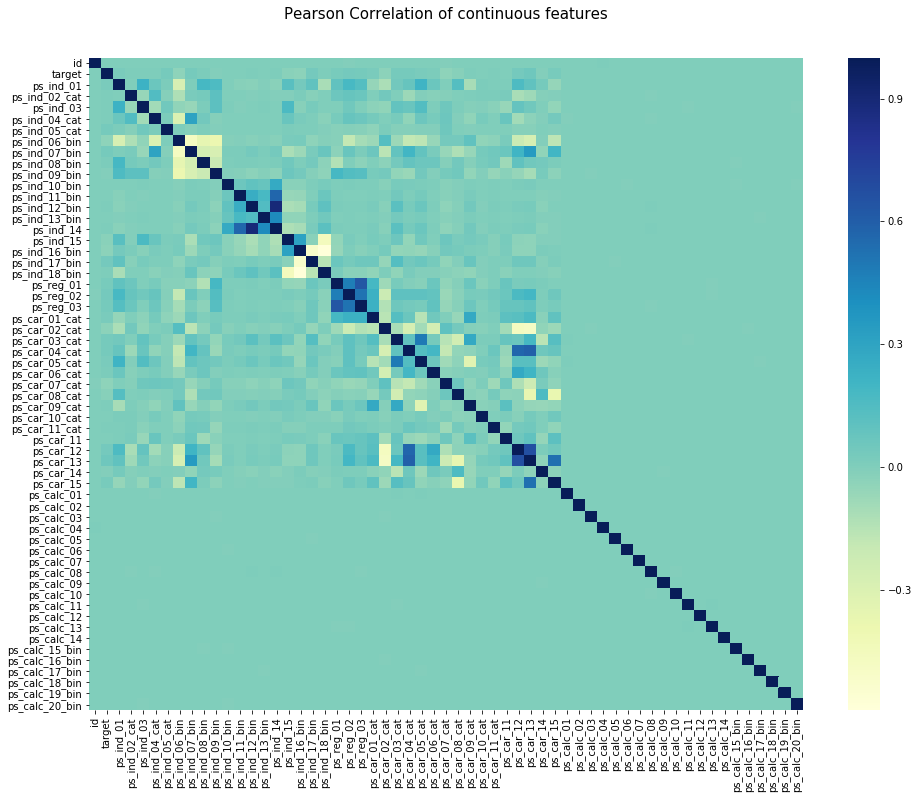

In [44]:
plt.figure(figsize=(16,12))
plt.title('Pearson Correlation of continuous features', y=1.05, size=15)
sns.heatmap(train.corr(),cmap="YlGnBu")

From the correlation map of features, we can see that the majority of the features display zero or no correlation to one another. This is a good news. There are eight pairs features that might have strong linear correlation as follow:
1. (ps_ind_12_bin, ps_ind_14)
2. (ps_ind_13_bin, ps_ind_14)
3. (ps_car_04_cat, ps_car_12)
4. (ps_car_04_cat, ps_car_13)
5. (ps_reg_01, ps_reg_03)
6. (ps_reg_02, ps_reg_03)
7. (ps_car_12, ps_car_13)
8. (ps_car_13, ps_car_15)